In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import ndimage
import random
from scipy.optimize import leastsq
from scipy import ndimage
from scipy.optimize import least_squares
from func import *
from scipy import stats
from matplotlib.colors import LogNorm
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
kernel = Gaussian2DKernel(x_stddev=0.05)
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.weight'] = 'light'
from matplotlib import cm

In [2]:
(x_BH,y_BH)=(49.6491,49.8141)

xmin = - x_BH*0.2 - 0.5*0.2
xmax = 0.2*(100 - x_BH) + 0.5*0.2
ymin = - y_BH*0.2 - 0.5*0.2
ymax = 0.2*(100 - y_BH) + 0.5*0.2

In [3]:
hdu = fits.open('/Volumes/Seagate/HE0040-1105 Extended/table_HE0040-1105_extended_double_gauss.fits')
data = hdu[1].data
amp_OIII = data['amp_OIII']
amp_OIII_err = data['amp_OIII_err']
amp_OIII_br = data['amp_OIII_br']
amp_OIII_br_err = data['amp_OIII_br_err']
vel_OIII = data['vel_OIII']
vel_OIII_err = data['vel_OIII_err']
vel_OIII_br = data['vel_OIII_br']
vel_OIII_br_err = data['vel_OIII_br_err']
vel_sigma_OIII = data['vel_sigma_OIII']
vel_sigma_OIII_err = data['vel_sigma_OIII_err']
vel_sigma_OIII_br = data['vel_sigma_OIII_br']
vel_sigma_OIII_br_err = data['vel_OIII_br_err']
w80 = data['w80']
w80_err = data['w80_err']
v5 = data['v5']
v5_err = data['v5_err']
x_cor = np.array([int(x) for x in data['x_cor']])
y_cor = np.array([int(x) for x in data['y_cor']])
vel_off = np.abs(vel_OIII_br - vel_OIII)
vel_off_err = np.sqrt(vel_OIII_err**2 + vel_OIII_br_err**2)
vel_syst = (vel_OIII/vel_OIII)*12568
hdu.close()

In [4]:
hdu = fits.open('/Volumes/Seagate/HE0040-1105 Extended/HE0040-1105.extended_cube.fits')
data = hdu[0].data
dim = np.shape(data)
hdu.close()

In [5]:
import seaborn as sns
sigma_eff_OIII = line_width_recons(vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
sigma_eff_OIII_br = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0) 
flux_OIII = amp_OIII*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII))
flux_OIII_br = amp_OIII_br*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_br))
   

s = flux_OIII+flux_OIII_br

for l in range(100):
    popt = np.zeros((10201,100),dtype=np.float32)
    sigma_eff_OIII = line_width_recons(np.random.normal(vel_sigma_OIII,vel_sigma_OIII_err),rest_line=5006.8,inst_res_fwhm=0)
    sigma_eff_OIII_br = line_width_recons(np.random.normal(vel_sigma_OIII_br,vel_sigma_OIII_br_err),rest_line=5006.8,inst_res_fwhm=0) 
    amp_eff_OIII = np.random.normal(amp_OIII,amp_OIII_err)
    amp_eff_OIII_br = np.random.normal(amp_OIII_br,amp_OIII_br_err)                                                      
    flux_OIII = amp_eff_OIII*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII))
    flux_OIII_br = amp_eff_OIII_br*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_br))
    F = flux_OIII + flux_OIII_br                                                      
    popt[:,l]=F
s_err = np.nanstd(popt,1)

In [6]:
gas_select = (s / s_err > 3) #& (vel_sigma_OIII_br/vel_sigma_OIII_br_err > 1) & (vel_sigma_OIII/vel_sigma_OIII_err > 1) 
dim = [0,101,101]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [7]:
s_map = np.full((dim[1],dim[2]) ,np.nan)
s_map[x_cor[gas_select],y_cor[gas_select]] = s[gas_select]

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


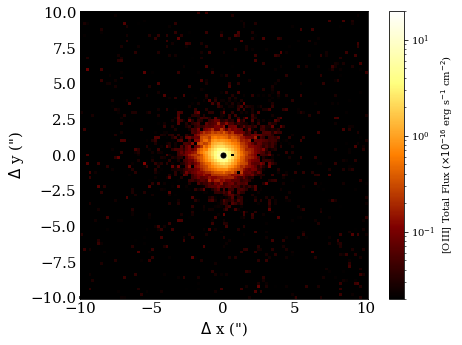

In [8]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])

cmap=cm.afmhot
#cmap = sns.cubehelix_palette(1, light=0.05,dark=0.95, as_cmap=True)
cmap.set_bad('k',1) # Make the NANs white

frame = plt.imshow(s_map, origin='lower', cmap=cmap, interpolation='None',vmin=0.02,vmax=20,extent=[xmin,xmax,ymin,ymax], norm=LogNorm())
cbar = plt.colorbar()
plt.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
plt.xlabel(r'$\Delta$ x (")',fontsize=15)
plt.ylabel(r'$\Delta$ y (")',fontsize=15)
plt.plot(0,0,'o',color='k',ms=5)

cbar.set_label(r"[OIII] Total Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$)",fontsize=10)

In [11]:
gas_select = (w80/ w80_err > 1) & (amp_OIII>0.005) & (amp_OIII_br>0.005)
dim = [0,101,101]

w80_map = np.full((dim[1],dim[2]) ,np.nan)
w80_map[x_cor[gas_select],y_cor[gas_select]] = w80[gas_select]# - vel_syst[gas_select]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


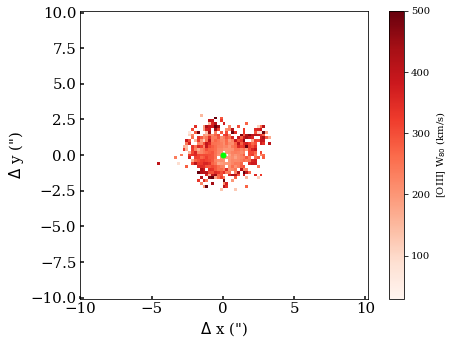

In [14]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])


cmap = cm.afmhot

cmap.set_bad('w',1) # Make the NANs white

frame = plt.imshow(w80_map, origin='lower', cmap='Reds', vmin=30,vmax=500,extent=[xmin,xmax,ymin,ymax],interpolation='None')
cbar = plt.colorbar()
plt.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
plt.xlabel(r'$\Delta$ x (")',fontsize=15)
plt.ylabel(r'$\Delta$ y (")',fontsize=15)
plt.plot(0,0,'o',color='Lime',ms=5)

cbar.set_label(r"[OIII] W$_{80}$ (km/s)")

In [15]:
gas_select = (np.abs(v5)/ v5_err > 1) & (amp_OIII>0.005) & (amp_OIII_br>0.005)
dim = [0,101,101]

v5_map = np.full((dim[1],dim[2]) ,np.nan)
v5_map[x_cor[gas_select],y_cor[gas_select]] = v5[gas_select]# - vel_syst[gas_select]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


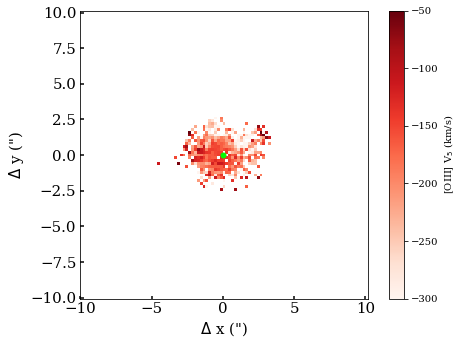

In [16]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])


cmap = cm.afmhot

cmap.set_bad('k',1) # Make the NANs white

frame = plt.imshow(v5_map, origin='lower', cmap='Reds', vmin=-300,vmax=-50,extent=[xmin,xmax,ymin,ymax],interpolation='None')
cbar = plt.colorbar()
plt.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
plt.xlabel(r'$\Delta$ x (")',fontsize=15)
plt.ylabel(r'$\Delta$ y (")',fontsize=15)
plt.plot(0,0,'o',color='Lime',ms=5)

cbar.set_label(r"[OIII] V$_{5}$ (km/s)")

In [125]:
hdu = fits.open('/Volumes/Seagate/3C264/Radio/3C264_MERLIN.fits')
header = hdu[0].header

In [129]:
amp_OIII_br_err

array([0.0004537 , 0.00024342, 0.00058478, ..., 0.00093841, 0.00057431,
       0.00064358], dtype=float32)

In [130]:
amp_OIII_br

array([7.8997161e-04, 3.4647397e-04, 6.0228870e-04, ..., 6.5501791e-04,
       7.1933639e-31, 2.0075918e-03], dtype=float32)